# ПРОЕКТ: Маркетинг

## Описание проекта

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

## Цель проекта:

Предсказать вероятность покупки в течение 90 дней.

__Главные задачи__:

- загрузить и изучить данные
- провести предобработку и исследовательский анализ
- сконструировать новые признаки
- проверить на мультиколлинеарность
- создать и обучить модели
- исследовать значимость признаков
- максимизировать метрику __ROC-AUC__ и оценить качество модели 

## Краткий план работы

| **№ п/п** | **Задача** | **Срок выполнения** |
| :---: | :--- | :---: |
|1.|Импортировать необходимые библиотеки. Загрузить данные. Провести их осмотр.|07.10.2024|
|2.|Провести предобработку данных. Принять решение по обработке пропусков и дубликатов.|07.10.2024|
|3.|Провести исследовательский и корелляционный анализ данных.|08.10.2024|
|4.|Провести подготовку данных. Отобрать признаки.|09.10.2024|
|5.|Подобрать гиперпараметры и обучить модель.|10.10.2024|
|6.|Получить прогнозы на тестовой выборке. Провести оценку качества ML-модели по метрике ROC_AUC.|11.10.2024|
|7.|Оценить важность признаков.|12.10.2024|
|8.|Сформулировать выводы.|13.10.2024|

## Описание данных:

### Файл `apparel-purchases.csv`

Содержит информацию о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук.

В таблице есть списки идентификаторов, к каким категориям относится товар. Часто это вложенные категории (например автотовары-аксессуары-освежители), но также может включать в начале списка маркер распродажи или маркер женщинам/мужчинам.

Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому могут меняться вложенности, например `['4', '28', '44', '1594']` или `['4', '44', '1594']`.

| **№ п/п** | **Наименование признака** | **Описание** |
| :---: | :--- | :--- |
|1.|__client_id__|Идентификатор клиента|
|2.|__quantity__|Количество единиц товара|
|3.|__price__|Цена товара|
|4.|__category_ids__|Идентификаторы категорий|
|5.|__date__|Дата покупки|
|6.|__message_id__|Идентификатор сообщения из рассылки|

### Файл `apparel-messages.csv`

Содержит рассылки, которые были отправлены клиентам из таблицы покупок.

| **№ п/п** | **Наименование признака** | **Описание** |
| :---: | :--- | :--- |
|1.|__bulk_campaign_id__|Идентификатор рассылки|
|2.|__client_id__|Идентификатор клиента|
|3.|__message_id__|Идентификатор сообщения|
|4.|__event__|Действие с сообщением (отправлено, открыто, покупка...)|
|5.|__channel__|Канал рассылки|
|6.|__date__|Дата действия|
|7.|__created_at__|Дата-время полностью|

### Файл `apparel-target_binary.csv`

Содержит рассылки, которые были отправлены клиентам из таблицы покупок.

| **№ п/п** | **Наименование признака** | **Описание** |
| :---: | :--- | :--- |
|1.|__client_id__|Идентификатор клиента|
|2.|__target__|Клиент совершил покупку в целевом периоде|


_Агрегированная по дням статистика по рассылкам._

### Файл `full_campaign_daily_event.csv`


| **№ п/п** | **Наименование признака** | **Описание** |
| :---: | :--- | :--- |
|1.|__date__|Дата|
|2.|__bulk_campaign_id__|Идентификатор рассылки|
|3.|__count_event*__|Общее количество каждого события event|
|4.|__nunique_event*__|Количество уникальных client_id в каждом событии|

\* _в именах колонок есть все типы событий event_

### Файл `full_campaign_daily_event_channel.csv`


| **№ п/п** | **Наименование признака** | **Описание** |
| :---: | :--- | :--- |
|1.|__date__|Дата|
|2.|__bulk_campaign_id__|Идентификатор рассылки|
|3.|__count_event*\_channel*__|Общее количество каждого события по каналам|
|4.|__nunique_event*\_channel*__|Количество уникальных client_id по событиям и каналам|

\* _в именах колонок есть все типы событий event и каналов рассылки channel_

## Импорт библиотек, определение констант, классов и функций

### Загрузка библиотек

In [1]:
# основные библиотеки
import sys
import os
import pandas as pd
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import warnings
import ast

from matplotlib.colors import to_rgba

# загружаем селекторы отбора признаков
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import f_classif

# загружаем инструмент для подбора гиперпараметров
import optuna
from optuna.integration import OptunaSearchCV
from optuna.exceptions import ExperimentalWarning

# загружаем функцию для измерения времени
from time import time

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# инструмент для проверки модели на адекватность 
from sklearn.dummy import DummyClassifier

# загружаем инструменты для подготовки данных
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder

# загружаем функции для работы с метриками
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, f1_score

# загружаем классы для создания кастомных трасформеров
from sklearn.base import BaseEstimator, TransformerMixin

# загружаем инструменты для работы с дисбалансом классов
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek

# библиотеку для работы с корреляцией
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# инструменты для отображения таблиц с использованием переменных
from IPython.display import display, Markdown as md

# инициализация констант
RANDOM_STATE = 42
TEST_SIZE = 0.25

# установка опции для отображения всех столбцов и чисел
pd.set_option('display.float_format', '{:,.6f}'.format)
pd.set_option("display.max.columns", None)
pd.set_option('display.max_colwidth', None)

### Класс для измерения времени выполнения кода

In [2]:
# класс для отсечки времени
class Timer:
    
    def __enter__(self):
        # запоминаем время начала
        self.start_time = time()
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        # рассчитываем время выполнения (текущее время - время начала)
        elapsed_time = time() - self.start_time
        # сохраняем последний результат
        self.time_result = self._format_seconds(elapsed_time)
        # выводим результат
        print(f'Время выполнения кода: {self.time_result}')
        
    # для форматирования секунд
    def _format_seconds(self, seconds):
        minutes = int(seconds // 60)
        remaining_seconds = np.round(seconds % 60, 1)
        return f"{minutes} мин. {remaining_seconds} сек."


### Функция для отображения пропусков

In [3]:
def display_na_rates(df):
    missing_values = pd.concat(
        [df.isna().sum(), df.isna().sum() / len(df)], axis=1
    )
    missing_values.columns = ['Missing values', 'Missing rate']
    missing_values = missing_values.sort_values(by='Missing values', ascending=False)
    missing_values['Missing rate'] = missing_values['Missing rate'].apply(lambda rate : f'{rate:.1%}')
    display(missing_values)
    pass

### Функция для вывода количества дубликатов в датасете

In [4]:
def display_duplicates_rate(df):
    count = df.duplicated().sum()
    rate = count / len(df)
    print(f'Явных дубликатов: {count} ({rate:.1%})')

### Функция для вывода количества уникальных значений в признаках

In [5]:
def display_unique(df):
    display(
        pd.DataFrame(
            data = df.nunique(), columns = ['Уникальных значений']
        )
    )

### Функция для вывода диаграммы SHAP-значений

In [6]:
# функция принимает на вход модель, подготовленный для нее набор признаков
# подпись к оси Y и название графика
def plot_shap_beeswarm(model, X, title, y_label):
    # используем библиотеку shap
    # используем Explainer, который автоматически подбирает нужный подкласс
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    shap.plots.beeswarm(
        shap_values,
        # передаем размерность в max_display
        max_display=len(X),
        show=False
    )
    fig, ax = plt.gcf(), plt.gca()
    ax.set_ylabel(y_label)
    ax.set_title(title, fontsize=12, fontweight='bold')
    plt.show()
    pass

### Функция для вывода матрицы корелляции

In [7]:
# функция принимает датасет и список количественных признаков
def plot_corr(df, interval_cols):
    # считаем корреляции
    phik_overview = phik_matrix(
        df,
        interval_cols=interval_cols
    )
    # визуализируем матрицу корреёёъэхзщляции
    plot_correlation_matrix(
        # передаём значения матрицы корреляции
        phik_overview.values,
        
        # указываем наименования столбцов
        x_labels=phik_overview.columns,
        
        # указываем наименования строк
        y_labels=phik_overview.index,
        
        # указываем цвет градиентной отрисовки
        vmin=0, vmax=1, color_map='Greens',
        
        # добавляем заголовок
        title=r'correlation $\phi_K$',
        
        # увеличиваем размер шрифта
        fontsize_factor=1.5,
        
        # увеличиваем размер графика
        figsize=(20, 15)
    )
    pass

### Функция для загрузки данных

In [8]:
# определение функции для инициализаци датасета
# функция принимает в качестве аргументов локальный путь, сетевой путь и разделитель для датасета
def fetch_data(local_path, url, sep=',', decimal='.'):
    
    # проверяет существует ли локальный файл csv
    if os.path.exists(local_path):
        
        # если да, то загружает локально
        data = pd.read_csv(local_path, sep=sep, decimal=decimal)
    else:
        
        # если нет, загружает файл из сети с выводом соответствующего уведомления
        print('Local file', local_path, 'does not exist.\nDownloading from', url)
        data = pd.read_csv(url, sep=sep, decimal=decimal)
        
    # функция возвращает объект <DataFrame>
    return data

### Функция вывода `markdown` текста

In [9]:
def print_md(text):
    display(md(text))

## Загрузка и ознакомление с данными

In [10]:
# объявление локальных путей к датасетам
purchases_local_path = './filtered_data/apparel-purchases.csv'
messages_local_path = './filtered_data/apparel-messages.csv'
target_local_path = './filtered_data/apparel-target_binary.csv'
event_local_path = './filtered_data/full_campaign_daily_event.csv'
event_channel_local_path = './filtered_data/full_campaign_daily_event_channel.csv'

Инициализируем датасеты с использованием метода `read_csv()` из библиотеки `pandas`.

In [11]:
purchases = pd.read_csv(purchases_local_path, sep=',', decimal='.')

In [12]:
messages = pd.read_csv(messages_local_path, sep=',', decimal='.')

In [13]:
target = pd.read_csv(target_local_path, sep=',', decimal='.')

In [14]:
agg_event = pd.read_csv(event_local_path, sep=',', decimal='.')

In [15]:
agg_event_channel = pd.read_csv(event_channel_local_path, sep=',', decimal='.')

Выводим результаты загрузки данных.

In [16]:
purchases.sample(5)

,client_id,quantity,price,category_ids,date,message_id
175276,1515915625590848696,1,53.000000,"['4', '1822', '1821', '1815']",2023-11-03,1515915625986576814-14053-6544a3a57b5ff
183860,1515915626001372165,1,749.000000,"['4', '28', '146', '548']",2023-12-21,1515915626001372165-14339-65814dda810ca
39380,1515915625489389247,1,249.000000,"['4', '28', '44', '428']",2022-09-12,1515915625488568346-6289-631ada397ce9a
98106,1515915625792421980,1,"2,599.000000","['4', '28', '62', '656']",2023-03-30,1515915625792421980-11387-64244e83b0129
195357,1515915625474433383,1,121.000000,"['6060', '6058', '6067', '5498']",2024-01-18,1515915625474433383-14468-65a0ffaf4d457


In [17]:
messages.sample(5)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
8491705,13955,1515915625557394136,1515915625557394136-13955-65291581d8926,send,mobile_push,2023-10-13,2023-10-13 10:03:53
151750,4617,1515915625488941074,1515915625488941074-4617-6290658c4591d,open,email,2022-05-27,2022-05-27 06:51:57
11320027,14433,1515915625468196295,1515915625468196295-14433-65952fb5eee4f,open,email,2024-01-06,2024-01-06 23:51:34
7190360,13696,1515915625477475593,1515915625477475593-13696-64e5e6ffc55a5,open,mobile_push,2023-08-23,2023-08-23 14:04:38
4713953,11760,1515915625488524443,1515915625488524443-11760-643674a688d07,send,email,2023-04-12,2023-04-12 13:55:07


In [18]:
target.sample(5)

,client_id,target
16469,1515915625491409635,0
32136,1515915625581325698,0
13205,1515915625490247922,0
7811,1515915625488290703,0
47388,1515915625962850129,0


In [19]:
agg_event.sample(5)

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,nunique_click,nunique_complain,nunique_hard_bounce,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
60306,2023-03-02,8626,0,2,0,48,0,0,0,0,3,0,2,0,47,0,0,0,0,3,0,0,0,0
19399,2022-09-04,4980,0,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0
22125,2022-09-17,5052,0,0,0,37,0,0,0,0,1,0,0,0,34,0,0,0,0,1,0,0,0,0
57734,2023-02-16,2423,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
116332,2024-03-16,14668,3,0,0,255,0,0,0,0,0,2,0,0,251,0,0,0,0,0,0,0,0,0


In [20]:
agg_event_channel.sample(5)

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,nunique_click_email,nunique_click_mobile_push,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_soft_bounce_email,nunique_subscribe_email,nunique_unsubscribe_email,count_hard_bounce_mobile_push,count_send_mobile_push,nunique_hard_bounce_mobile_push,nunique_send_mobile_push,count_hard_bounce_email,count_hbq_spam_email,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
98519,2023-12-26,14197,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
94144,2023-11-29,13683,0,0,3,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
78480,2023-06-10,13157,15503,0,69346,0,363,0,0,14,488,10829,0,67832,0,278,0,0,14,455,0,0,0,0,0,0,0,0,0,0,0,0,86,86,0,0
127835,2024-05-02,13749,0,0,5,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
99541,2023-12-30,14407,0,659,0,1643,0,3,0,0,0,0,560,0,1633,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Предобработка данных

### Работа с дубликатами

Проверим количество явных полных дубликатов в наборах `purchases` и`messages`.

In [21]:
display_duplicates_rate(purchases)

Явных дубликатов: 73020 (36.1%)


In [22]:
display_duplicates_rate(messages)

Явных дубликатов: 48610 (0.4%)


Набор данных `messages` содержит колонку `created_at`, в которой указано время с точностью до секунд. Такие дубликаты необходимо удалить.

Датасет `purchases` не имеет признака, который был бы абсолютно уникален для каждого наблюдения, а дубликаты могут быть разными покупками, поэтому их оставим.

In [23]:
messages = messages.drop_duplicates()

In [24]:
display_duplicates_rate(messages)

Явных дубликатов: 0 (0.0%)


### Работа с пропусками

Проверим количество пропусков в наборах `purchases` и`messages`.

In [25]:
display_na_rates(purchases)

,Missing values,Missing rate
client_id,0,0.0%
quantity,0,0.0%
price,0,0.0%
category_ids,0,0.0%
date,0,0.0%
message_id,0,0.0%


In [26]:
display_na_rates(messages)

,Missing values,Missing rate
bulk_campaign_id,0,0.0%
client_id,0,0.0%
message_id,0,0.0%
event,0,0.0%
channel,0,0.0%
date,0,0.0%
created_at,0,0.0%


Пропусков нет.

### Работа с типами данных

Преобразуем колонки даты и времени к типу `datetime`.

In [27]:
purchases['date'] = pd.to_datetime(
    purchases.loc[:, 'date'], format='%Y-%m-%d'
)

In [28]:
messages['date'] = pd.to_datetime(
    messages.loc[:, 'date'], format='%Y-%m-%d'
)

In [29]:
messages['created_at'] = pd.to_datetime(
    messages.loc[:, 'created_at'], format='%Y-%m-%d %H:%M:%S'
)

### Промежуточные выводы по предобработке данных:

- данные соответствуют описанию
- в данных нет пропусков
- данные содержат множество дуюликатов. Дубликаты в наборе `messages` были удалены, так как время и дата событий совпадают с точностью до секунд. Дубликаты в наборе `purchases` сохранены, так как отсутствует информативный признак, который позволял бы понять, что запись дублирована.
- нейминг столбцов соостветствует принятым соглашениям
- колонки с датами были приведены к типу `datetime`

## Работа с признаками

### Признак `total_invoice`

Создаем признак `total_invoice` (суммарный чек покупки). Для этого стоимость товара `price` умножаем на его количество `quantity`.

In [30]:
purchases['total_invoice'] = purchases['price'] * purchases['quantity']

Проверяем результат.

In [31]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   client_id      202208 non-null  int64         
 1   quantity       202208 non-null  int64         
 2   price          202208 non-null  float64       
 3   category_ids   202208 non-null  object        
 4   date           202208 non-null  datetime64[ns]
 5   message_id     202208 non-null  object        
 6   total_invoice  202208 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 10.8+ MB


In [32]:
purchases.sample()

,client_id,quantity,price,category_ids,date,message_id,total_invoice
199328,1515915625581417190,1,727.000000,"['4', '28', '57', '431']",2024-02-07,1515915625488097098-14608-65c33fa65b617,727.000000


### Сводные показатели рассылочных кампаний (из датасета `agg_event_channel`)

Создадим таблицу с показателями по рассылочным кампаниям, содердащую информацию о средних количествах событий в день.

In [33]:
bulk_rates = agg_event_channel.groupby('bulk_campaign_id').agg({
    'date': 'nunique',
    'nunique_click_email': 'sum',
    'nunique_click_mobile_push': 'sum',
    'nunique_close_mobile_push': 'sum',
    'nunique_complain_email': 'sum',
    'nunique_hard_bounce_email': 'sum',
    'nunique_hard_bounce_mobile_push': 'sum',
    'nunique_hbq_spam_email': 'sum',
    'nunique_open_email': 'sum',
    'nunique_open_mobile_push': 'sum',
    'nunique_purchase_email': 'sum',
    'nunique_purchase_mobile_push': 'sum',
    'nunique_send_email': 'sum',
    'nunique_send_mobile_push': 'sum',
    'nunique_soft_bounce_email': 'sum',
    'nunique_soft_bounce_mobile_push': 'sum',
    'nunique_subscribe_email': 'sum',
    'nunique_unsubscribe_email': 'sum',
    'count_click_email': 'sum',
    'count_click_mobile_push': 'sum',
    'count_close_mobile_push': 'sum',
    'count_complain_email': 'sum',
    'count_hard_bounce_email': 'sum',
    'count_hard_bounce_mobile_push': 'sum',
    'count_hbq_spam_email': 'sum',
    'count_open_email': 'sum',
    'count_open_mobile_push': 'sum',
    'count_purchase_email': 'sum',
    'count_purchase_mobile_push': 'sum',
    'count_send_email': 'sum',
    'count_send_mobile_push': 'sum',
    'count_soft_bounce_email': 'sum',
    'count_soft_bounce_mobile_push': 'sum',
    'count_subscribe_email': 'sum',
    'count_unsubscribe_email': 'sum'
})

Разделим количество событий на количество дней в кампании.

In [34]:
for col_name in bulk_rates.columns:
    if col_name != 'date':
        bulk_rates[col_name] = bulk_rates[col_name] / bulk_rates['date']

In [35]:
bulk_rates = bulk_rates.drop('date', axis=1)

Получаем такой результат.

In [36]:
bulk_rates.sample(5)

,nunique_click_email,nunique_click_mobile_push,nunique_close_mobile_push,nunique_complain_email,nunique_hard_bounce_email,nunique_hard_bounce_mobile_push,nunique_hbq_spam_email,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_send_email,nunique_send_mobile_push,nunique_soft_bounce_email,nunique_soft_bounce_mobile_push,nunique_subscribe_email,nunique_unsubscribe_email,count_click_email,count_click_mobile_push,count_close_mobile_push,count_complain_email,count_hard_bounce_email,count_hard_bounce_mobile_push,count_hbq_spam_email,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_send_email,count_send_mobile_push,count_soft_bounce_email,count_soft_bounce_mobile_push,count_subscribe_email,count_unsubscribe_email
bulk_campaign_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4696,11.177914,0.000000,0.000000,0.650307,0.030675,0.000000,0.003067,295.610429,0.000000,0.199387,0.000000,852.975460,0.000000,3.490798,0.000000,0.042945,1.815951,14.582822,0.000000,0.000000,0.656442,0.030675,0.000000,0.003067,310.371166,0.000000,0.273006,0.000000,852.975460,0.000000,3.490798,0.000000,0.046012,1.929448
13639,0.000000,14.250000,0.000000,0.000000,0.000000,4.250000,0.000000,0.000000,497.000000,0.000000,0.750000,0.000000,798.750000,0.000000,0.000000,0.000000,0.000000,0.000000,14.250000,0.000000,0.000000,0.000000,4.250000,0.000000,0.000000,514.250000,0.000000,0.750000,0.000000,798.750000,0.000000,0.000000,0.000000,0.000000
14698,0.000000,1.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.125000,0.000000,0.000000,0.000000,5.125000,0.000000,0.000000,0.000000,0.000000,0.000000,1.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.250000,0.000000,0.000000,0.000000,5.125000,0.000000,0.000000,0.000000,0.000000
14216,13.023952,0.000000,0.000000,0.000000,0.197605,0.000000,0.029940,500.604790,0.000000,0.029940,0.000000,"3,536.323353",0.000000,24.916168,0.000000,0.113772,5.041916,16.568862,0.000000,0.000000,0.000000,0.197605,0.000000,0.029940,511.922156,0.000000,0.029940,0.000000,"3,536.323353",0.000000,24.916168,0.000000,0.113772,5.353293
8462,9.913462,0.000000,0.000000,0.259615,0.115385,0.000000,0.000000,47.067308,0.000000,0.067308,0.000000,707.125000,0.000000,2.432692,0.000000,0.028846,0.644231,13.173077,0.000000,0.000000,0.269231,0.115385,0.000000,0.000000,47.692308,0.000000,0.067308,0.000000,707.125000,0.000000,2.432692,0.000000,0.028846,0.682692


Соединим ее с таблицей `purchase`. Для этого выделим `bulk_campaign_id` из значения `message_id`.

In [37]:
purchases['bulk_campaign_id'] = purchases.message_id.apply(
    lambda x: int(x.split('-')[1])
)

In [38]:
purchases = purchases.merge(bulk_rates, on='bulk_campaign_id', how='left')

Обработаем появившиеся пропуски.

In [39]:
display_na_rates(purchases)

,Missing values,Missing rate
nunique_soft_bounce_email,39,0.0%
nunique_soft_bounce_mobile_push,39,0.0%
nunique_unsubscribe_email,39,0.0%
count_click_email,39,0.0%
count_click_mobile_push,39,0.0%
count_close_mobile_push,39,0.0%
count_complain_email,39,0.0%
count_hard_bounce_email,39,0.0%
count_hard_bounce_mobile_push,39,0.0%
count_hbq_spam_email,39,0.0%


In [40]:
purchases = purchases.fillna(0)

In [41]:
display_na_rates(purchases)

,Missing values,Missing rate
client_id,0,0.0%
count_hbq_spam_email,0,0.0%
nunique_subscribe_email,0,0.0%
nunique_unsubscribe_email,0,0.0%
count_click_email,0,0.0%
count_click_mobile_push,0,0.0%
count_close_mobile_push,0,0.0%
count_complain_email,0,0.0%
count_hard_bounce_email,0,0.0%
count_hard_bounce_mobile_push,0,0.0%


### Формирование датасета `features` для обучения и тестирования моделей

Начнем формирование датасета `features` с признаками с такой структурой:

|`client_id`|`features...`|`...`|`...`|``target``|
|:-:|:-:|:-:|:-:|:-:|

Сгруппируем датасет по `client_id`. Сохраним полученный датасет в переменную `features`.
В качестве агрегации для признаков применим:

- `total_invoice` - среднее
- `client_id` - количество
- `date` - количество уникальных значений

In [42]:
features = purchases \
    .groupby('client_id') \
    .agg({
        'total_invoice': 'mean', # средний чек
        'client_id': 'count', # количество покупок
        'date': 'nunique', # количество уникальных дат
        # средние показатели по типам событий
        'nunique_click_email': 'mean',
        'nunique_click_mobile_push': 'mean',
        'nunique_close_mobile_push': 'mean',
        'nunique_complain_email': 'mean',
        'nunique_hard_bounce_email': 'mean',
        'nunique_hard_bounce_mobile_push': 'mean',
        'nunique_hbq_spam_email': 'mean',
        'nunique_open_email': 'mean',
        'nunique_open_mobile_push': 'mean',
        'nunique_purchase_email': 'mean',
        'nunique_purchase_mobile_push': 'mean',
        'nunique_send_email': 'mean',
        'nunique_send_mobile_push': 'mean',
        'nunique_soft_bounce_email': 'mean',
        'nunique_soft_bounce_mobile_push': 'mean',
        'nunique_subscribe_email': 'mean',
        'nunique_unsubscribe_email': 'mean',
        'count_click_email': 'mean',
        'count_click_mobile_push': 'mean',
        'count_close_mobile_push': 'mean',
        'count_complain_email': 'mean',
        'count_hard_bounce_email': 'mean',
        'count_hard_bounce_mobile_push': 'mean',
        'count_hbq_spam_email': 'mean',
        'count_open_email': 'mean',
        'count_open_mobile_push': 'mean',
        'count_purchase_email': 'mean',
        'count_purchase_mobile_push': 'mean',
        'count_send_email': 'mean',
        'count_send_mobile_push': 'mean',
        'count_soft_bounce_email': 'mean',
        'count_soft_bounce_mobile_push': 'mean',
        'count_subscribe_email': 'mean',
        'count_unsubscribe_email': 'mean'
    })

Установим названия колонок.

In [43]:
features = features.rename(columns={
    'total_invoice': 'avg_total_invoice',
    'client_id': 'purchases_count',
    'date': 'unique_days_count'
})

In [44]:
features.sample(5)

,avg_total_invoice,purchases_count,unique_days_count,nunique_click_email,nunique_click_mobile_push,nunique_close_mobile_push,nunique_complain_email,nunique_hard_bounce_email,nunique_hard_bounce_mobile_push,nunique_hbq_spam_email,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_send_email,nunique_send_mobile_push,nunique_soft_bounce_email,nunique_soft_bounce_mobile_push,nunique_subscribe_email,nunique_unsubscribe_email,count_click_email,count_click_mobile_push,count_close_mobile_push,count_complain_email,count_hard_bounce_email,count_hard_bounce_mobile_push,count_hbq_spam_email,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_send_email,count_send_mobile_push,count_soft_bounce_email,count_soft_bounce_mobile_push,count_subscribe_email,count_unsubscribe_email
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1515915625764153522,221.350000,20,1,0.000000,"1,308.666667",0.000000,0.000000,0.000000,"1,221.500000",0.000000,0.000000,"37,898.444444",0.000000,13.611111,0.000000,"109,978.777778",0.000000,0.000000,0.000000,0.000000,0.000000,"2,092.777778",0.000000,0.000000,0.000000,"1,221.500000",0.000000,0.000000,"38,069.000000",0.000000,17.555556,0.000000,"109,978.777778",0.000000,0.000000,0.000000,0.000000
1515915625488703270,999.000000,1,1,17.408511,0.000000,0.000000,0.000000,0.817021,0.000000,0.012766,145.855319,0.000000,0.204255,0.000000,"1,753.970213",0.000000,11.808511,0.000000,0.025532,2.012766,22.885106,0.000000,0.000000,0.000000,0.821277,0.000000,0.012766,148.714894,0.000000,0.246809,0.000000,"1,753.970213",0.000000,11.808511,0.000000,0.025532,2.123404
1515915625559308108,"1,084.500000",2,1,0.000000,"3,729.228571",0.000000,0.000000,0.000000,"2,892.628571",0.000000,0.000000,"83,769.400000",0.000000,12.114286,0.000000,"180,606.971429",0.000000,0.000000,0.000000,0.000000,0.000000,"6,175.371429",0.000000,0.000000,0.000000,"2,892.628571",0.000000,0.000000,"84,589.257143",0.000000,14.828571,0.000000,"180,606.971429",0.000000,0.000000,0.000000,0.000000
1515915625566854074,"1,699.000000",4,3,62.265519,0.000000,0.000000,4.700179,2.165182,0.000000,0.216456,841.822095,0.000000,1.293225,0.000000,"8,531.397558",0.000000,37.361936,0.000000,0.340563,12.401079,81.216241,0.000000,0.000000,4.761611,2.178002,0.000000,0.216456,889.656577,0.000000,1.655818,0.000000,"8,531.397558",0.000000,53.877625,0.000000,0.351956,13.185131
1515915625556835932,"2,099.000000",2,1,235.512821,0.000000,0.000000,5.557692,10.948718,0.000000,0.557692,"2,274.852564",0.000000,7.153846,0.000000,"33,133.910256",0.000000,154.846154,0.000000,1.371795,39.987179,307.301282,0.000000,0.000000,5.570513,10.948718,0.000000,0.557692,"2,328.153846",0.000000,9.775641,0.000000,"33,133.910256",0.000000,154.878205,0.000000,1.532051,43.288462


### Данных по типам событий для клиента

Добавим в датасет `features` сводные данные по взамиодействию  с клиентом.

In [45]:
messages['event_channel'] = \
    messages['event'] \
    + '_' \
    + messages['channel']

In [46]:
for event_channel in messages['event_channel'].unique():
    features[event_channel] = 0

In [47]:
for client in messages.groupby('client_id'):
    if client[0] in features.index:
        for index, value in client[1].event_channel.value_counts().items():
            features.loc[client[0], index] = value

In [48]:
features.sample(3)

,avg_total_invoice,purchases_count,unique_days_count,nunique_click_email,nunique_click_mobile_push,nunique_close_mobile_push,nunique_complain_email,nunique_hard_bounce_email,nunique_hard_bounce_mobile_push,nunique_hbq_spam_email,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_send_email,nunique_send_mobile_push,nunique_soft_bounce_email,nunique_soft_bounce_mobile_push,nunique_subscribe_email,nunique_unsubscribe_email,count_click_email,count_click_mobile_push,count_close_mobile_push,count_complain_email,count_hard_bounce_email,count_hard_bounce_mobile_push,count_hbq_spam_email,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_send_email,count_send_mobile_push,count_soft_bounce_email,count_soft_bounce_mobile_push,count_subscribe_email,count_unsubscribe_email,open_email,click_email,purchase_email,click_mobile_push,send_email,unsubscribe_email,hbq_spam_email,send_mobile_push,hard_bounce_mobile_push,open_mobile_push,purchase_mobile_push,subscribe_email,soft_bounce_email,hard_bounce_email,complain_email,close_mobile_push,soft_bounce_mobile_push
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1515915625623206852,"1,199.000000",2,1,172.141791,0.000000,0.000000,4.385572,1.733831,0.000000,0.007463,960.417910,0.000000,0.957711,0.000000,"7,412.500000",0.000000,13.097015,0.000000,0.246269,11.228856,226.243781,0.000000,0.000000,4.420398,1.733831,0.000000,0.007463,"1,015.216418",0.000000,1.181592,0.000000,"7,412.502488",0.000000,13.097015,0.000000,0.258706,11.898010,10,5,2,0,32,0,0,0,0,0,0,0,0,0,0,0,0
1515915625488168992,"1,499.000000",1,1,85.329114,0.000000,0.000000,7.772152,3.131646,0.000000,0.432911,"1,085.253165",0.000000,2.156962,0.000000,"12,750.481013",0.000000,66.037975,0.000000,0.572152,19.731646,112.916456,0.000000,0.000000,7.888608,3.131646,0.000000,0.432911,"1,148.124051",0.000000,2.792405,0.000000,"12,750.481013",0.000000,66.040506,0.000000,0.594937,20.969620,5,6,1,0,148,0,0,0,0,0,0,0,0,0,0,0,0
1515915625601907856,782.333333,3,1,156.179487,0.000000,0.000000,1.730769,1.346154,0.000000,0.057692,"1,913.134615",0.000000,1.692308,0.000000,"10,526.397436",0.000000,60.615385,0.000000,0.532051,12.102564,216.608974,0.000000,0.000000,1.730769,1.346154,0.000000,0.057692,"1,958.685897",0.000000,2.115385,0.000000,"10,526.397436",0.000000,60.615385,0.000000,0.583333,13.179487,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [49]:
display_na_rates(features)

,Missing values,Missing rate
avg_total_invoice,0,0.0%
click_mobile_push,0,0.0%
count_purchase_email,0,0.0%
count_purchase_mobile_push,0,0.0%
count_send_email,0,0.0%
count_send_mobile_push,0,0.0%
count_soft_bounce_email,0,0.0%
count_soft_bounce_mobile_push,0,0.0%
count_subscribe_email,0,0.0%
count_unsubscribe_email,0,0.0%


Соединим с таргетом.

In [50]:
print_md(f'Размерность датасета `features` до объединения с таргетом: **{features.shape}**')

Размерность датасета `features` до объединения с таргетом: **(49849, 54)**

In [51]:
features = features.join(target.set_index('client_id'))

In [52]:
print_md(f'Размерность датасета `features` после объединения с таргетом: **{features.shape}**')

Размерность датасета `features` после объединения с таргетом: **(49849, 55)**

Приведем `avg_total_invoice` к целочисленному типу.

In [53]:
features.avg_total_invoice = features.avg_total_invoice.astype(int)

## Корелляционный анализ данных

Признаки с показателями рассылочных кампаний.

In [54]:
bulk_nunique_rates = [
    'nunique_click_email',
    'nunique_click_mobile_push',
    'nunique_close_mobile_push',
    'nunique_complain_email',
    'nunique_hard_bounce_email',
    'nunique_hard_bounce_mobile_push',
    'nunique_hbq_spam_email',
    'nunique_open_email',
    'nunique_open_mobile_push',
    'nunique_purchase_email',
    'nunique_purchase_mobile_push',
    'nunique_send_email',
    'nunique_send_mobile_push',
    'nunique_soft_bounce_email',
    'nunique_soft_bounce_mobile_push',
    'nunique_subscribe_email',
    'nunique_unsubscribe_email'
]

In [55]:
bulk_count_rates = [
    'count_click_email',
    'count_click_mobile_push',
    'count_close_mobile_push',
    'count_complain_email',
    'count_hard_bounce_email',
    'count_hard_bounce_mobile_push',
    'count_hbq_spam_email',
    'count_open_email',
    'count_open_mobile_push',
    'count_purchase_email',
    'count_purchase_mobile_push',
    'count_send_email',
    'count_send_mobile_push',
    'count_soft_bounce_email',
    'count_soft_bounce_mobile_push',
    'count_subscribe_email',
    'count_unsubscribe_email',
]

Признаки с показателями рекламного взаимодействия с клиентов.

In [56]:
client_events = [
    'open_email',
    'click_email',
    'purchase_email',
    'click_mobile_push',
    'send_email',
    'unsubscribe_email',
    'hbq_spam_email',
    'send_mobile_push',
    'hard_bounce_mobile_push',
    'open_mobile_push',
    'purchase_mobile_push',
    'subscribe_email',
    'soft_bounce_email',
    'hard_bounce_email',
    'complain_email',
    'close_mobile_push',
    'soft_bounce_mobile_push'
]

Агрегированные дагнные по покупкам.

In [57]:
purchases_features = [
    'unique_days_count',
    'purchases_count',
    'avg_total_invoice'
]

Выводим матрицы корелляции.

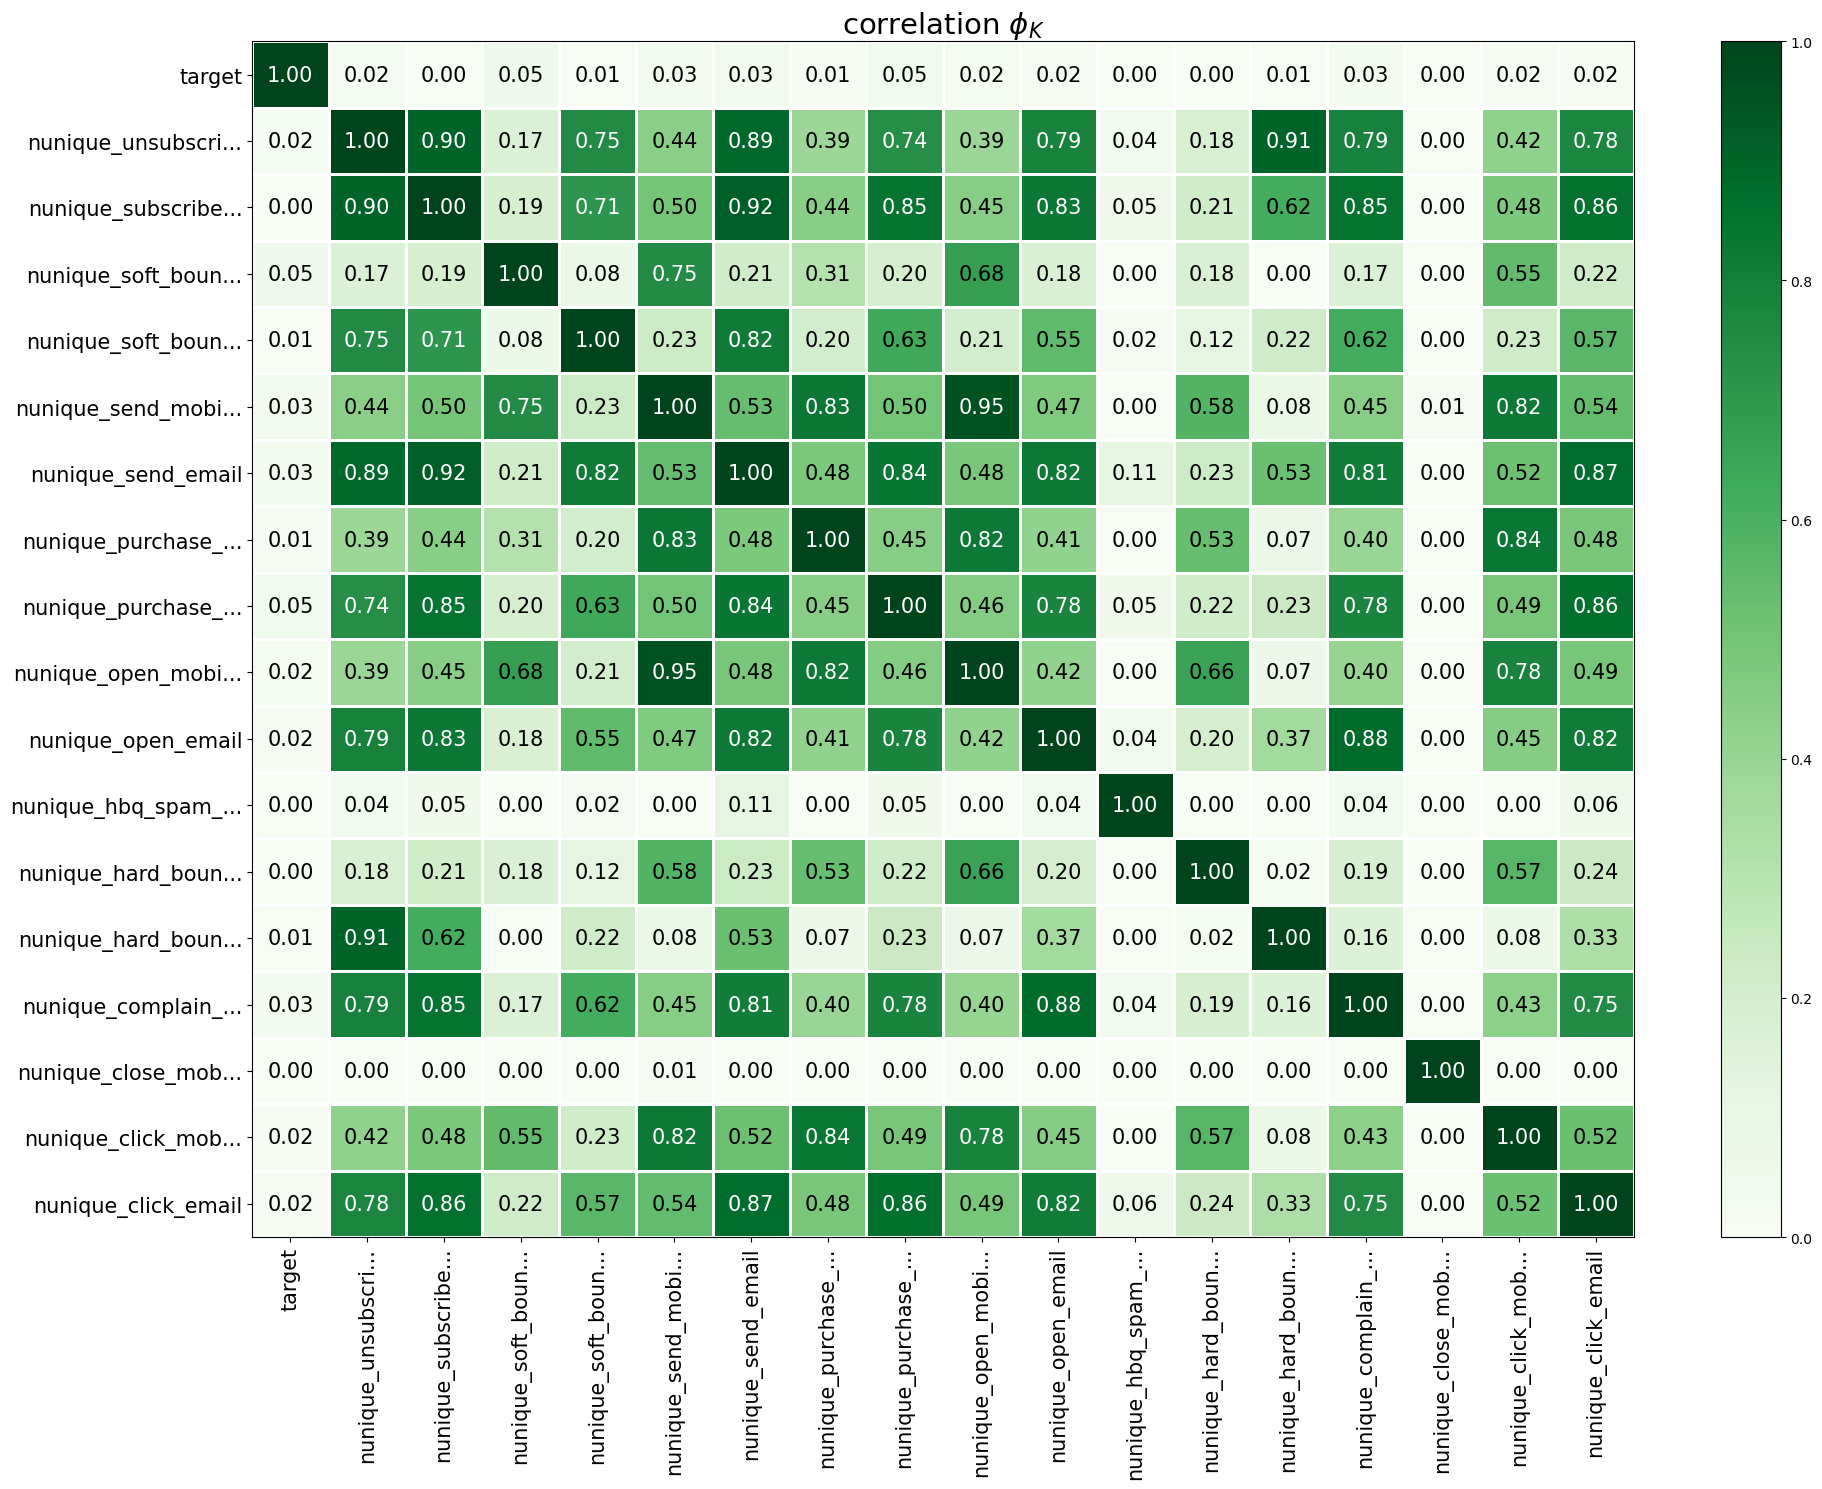

In [58]:
plot_corr(
    df=features[bulk_nunique_rates + ['target']],
    interval_cols=bulk_nunique_rates
)

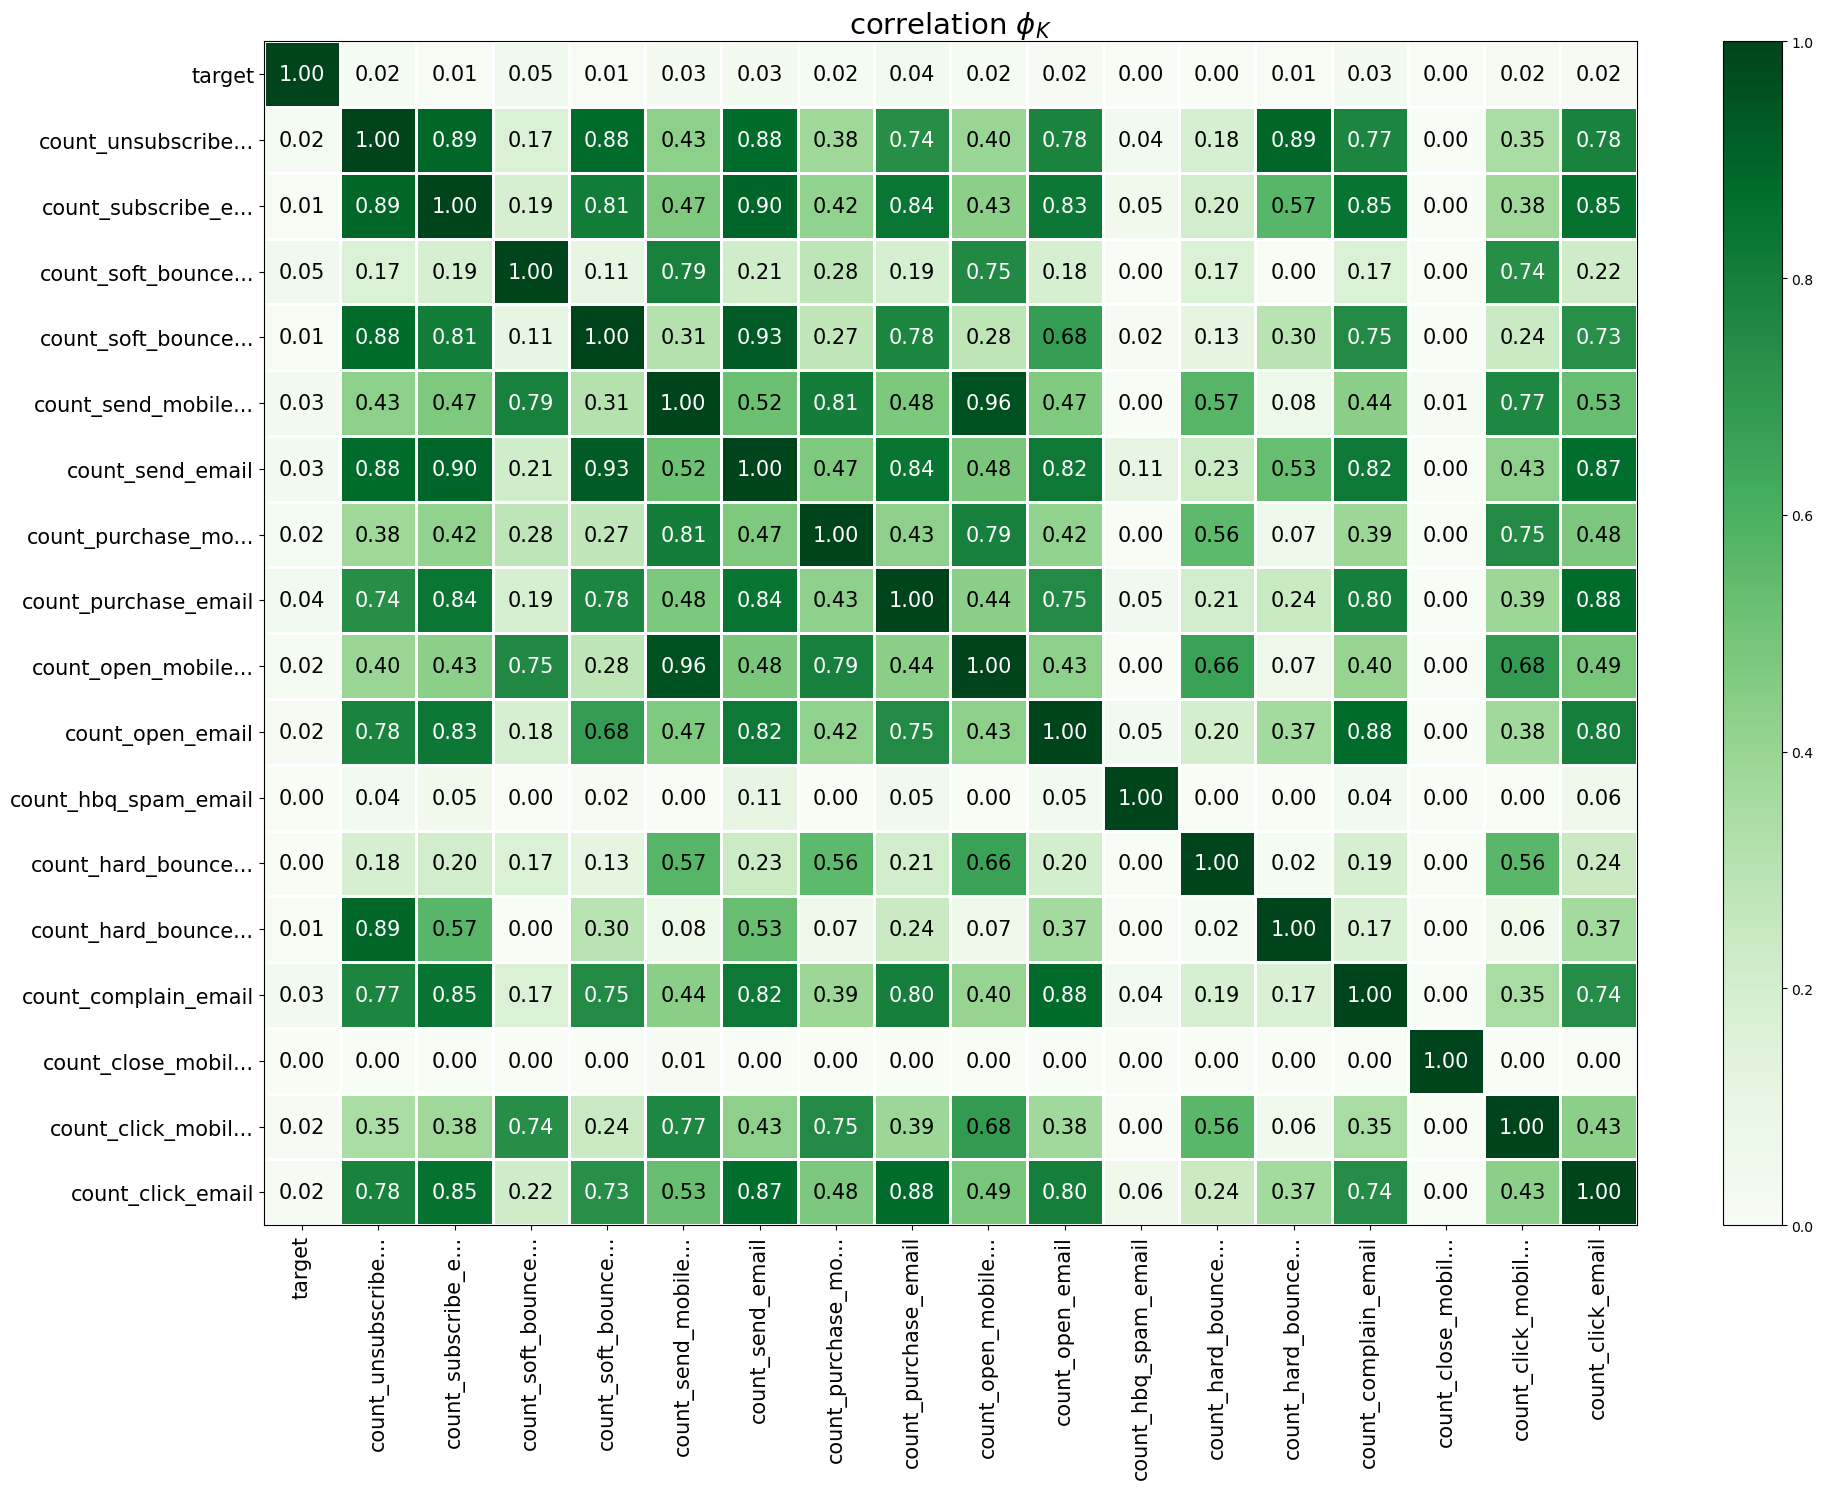

In [59]:
plot_corr(
    df=features[bulk_count_rates + ['target']],
    interval_cols=bulk_count_rates
)

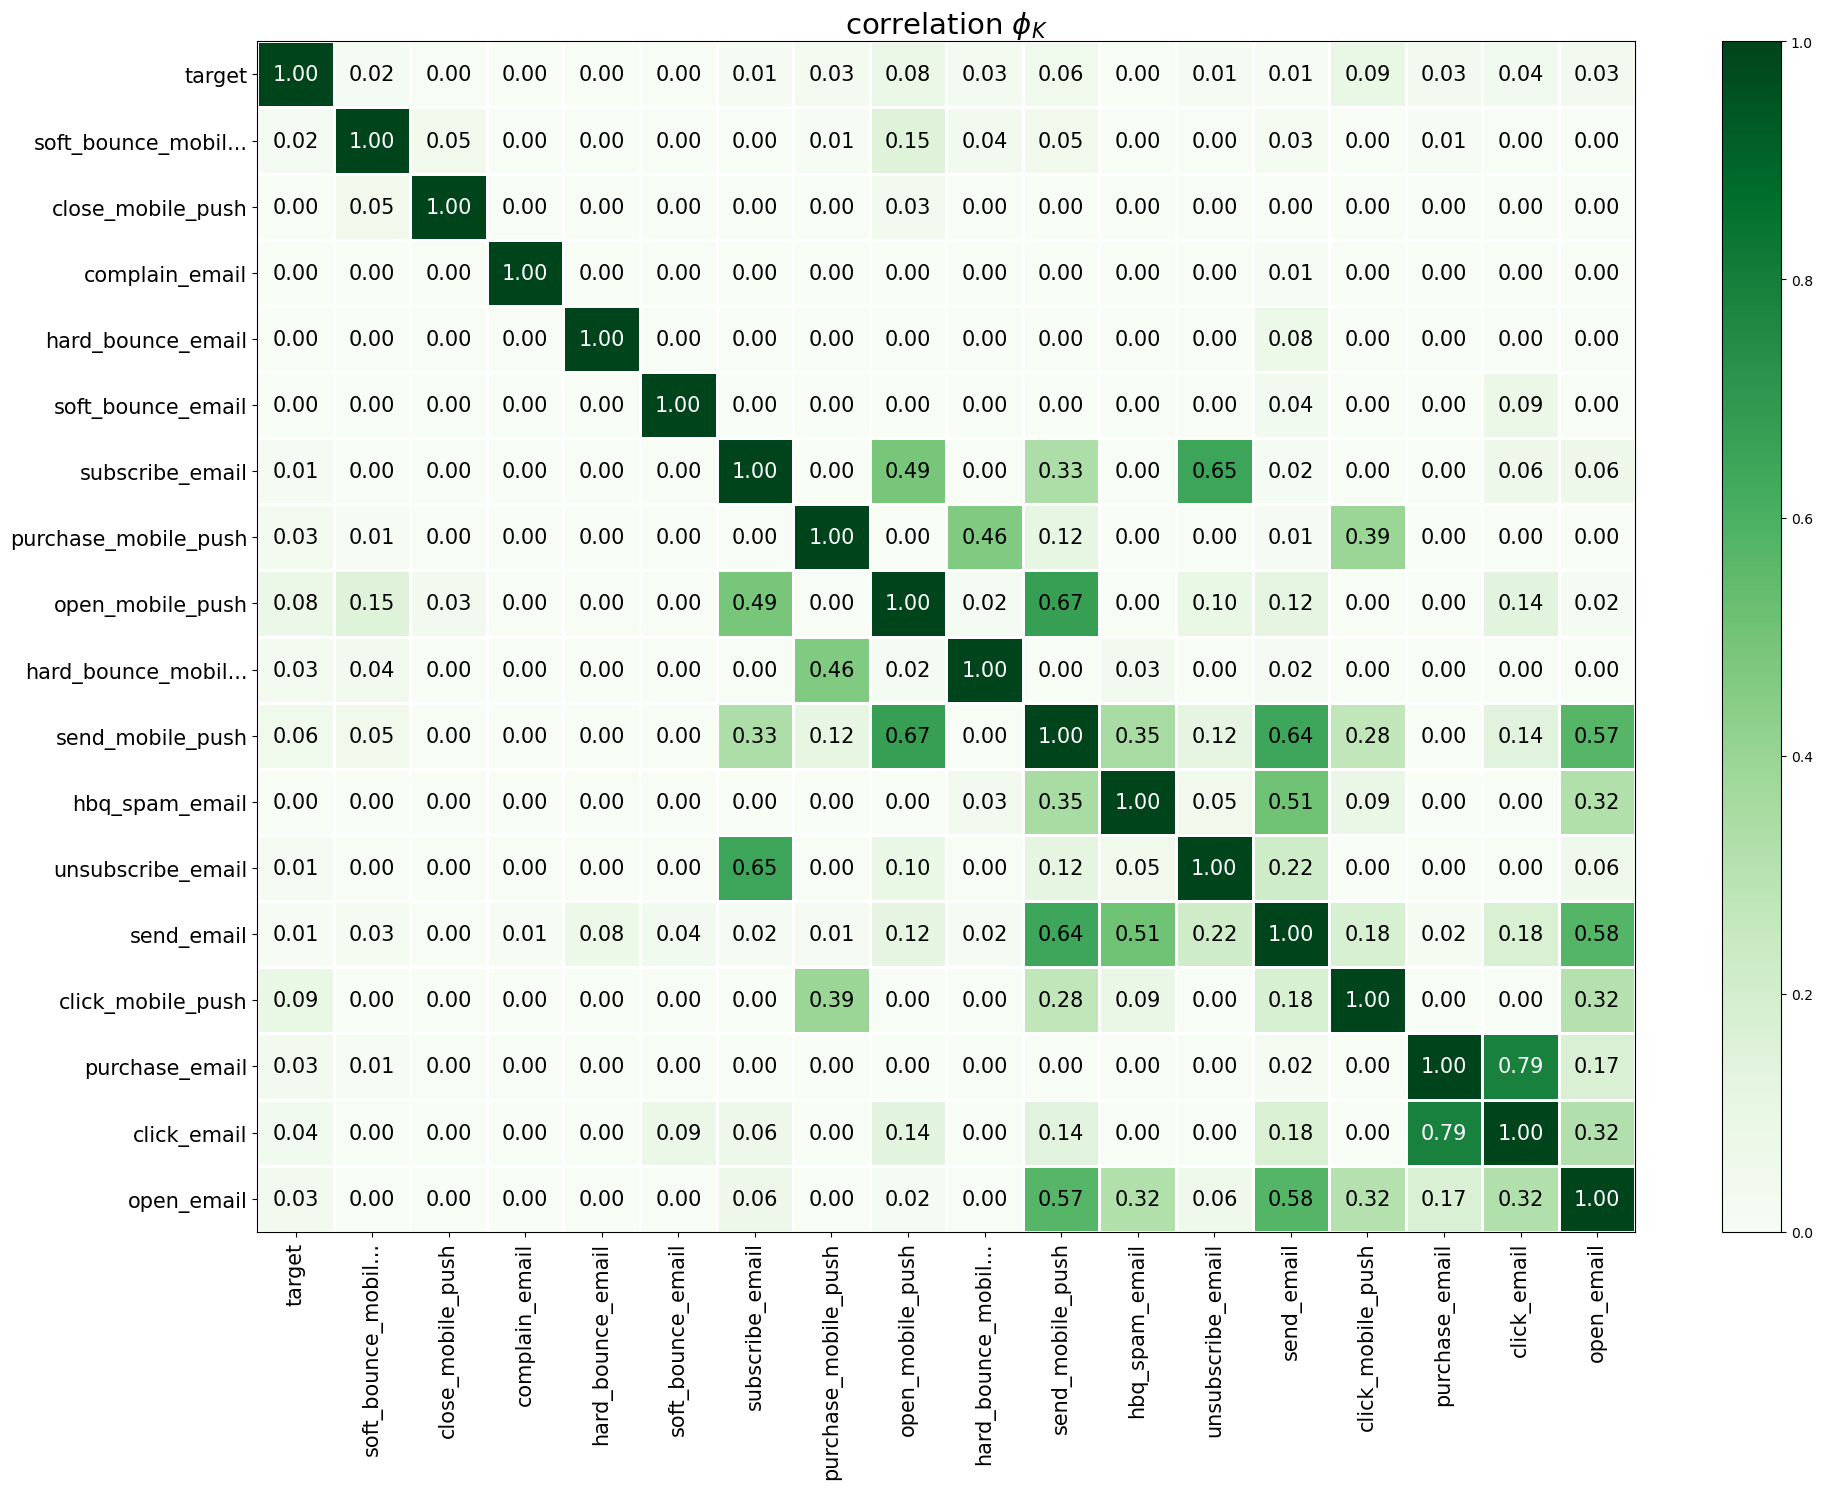

In [60]:
plot_corr(
    df=features[client_events + ['target']],
    interval_cols=client_events
)

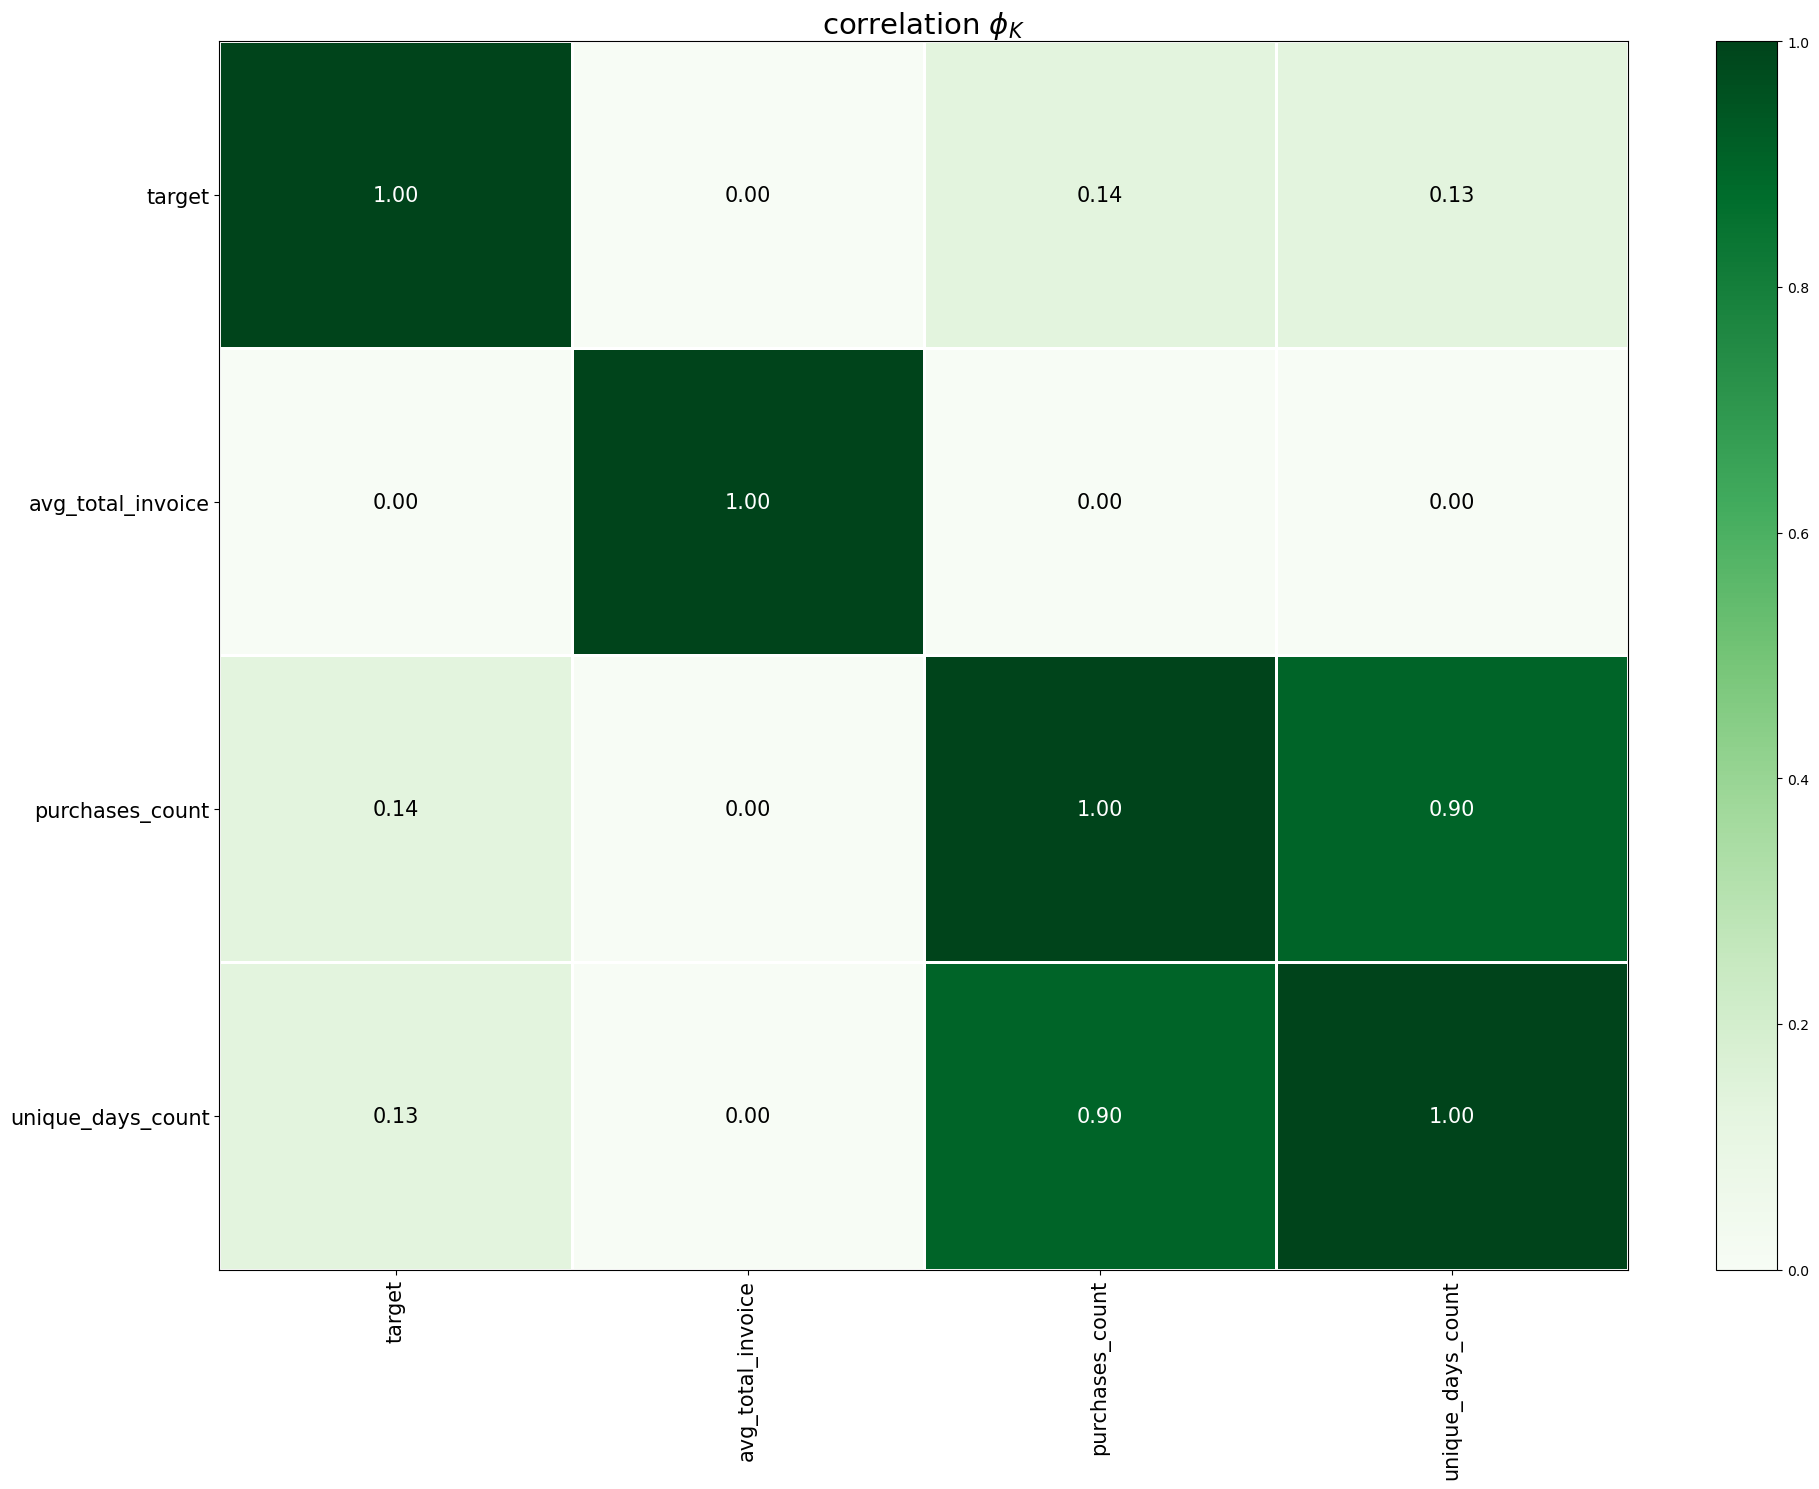

In [61]:
plot_corr(
    df=features[purchases_features + ['target']],
    interval_cols=['avg_total_invoice']
)

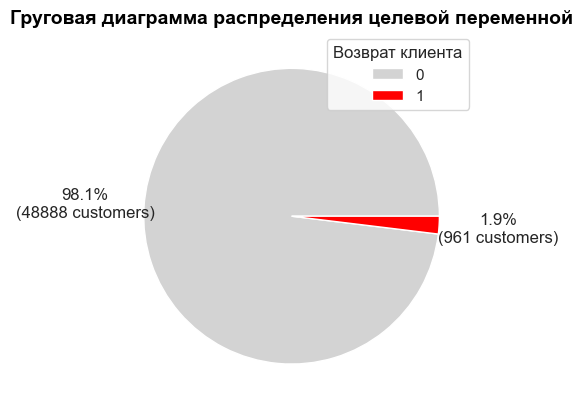

In [62]:
# получаем <ax>
fig, ax = plt.subplots()

# устанавливаем тему
sns.set_theme(style="whitegrid")

# определяем функцию для возврата процентов
# для подписей на круговой диаграмме
def get_percent_with_count(percent, allvals):
    absolute = int(np.round(percent/100.*np.sum(allvals)))
    return f"{percent:.1f}%\n({absolute:d} customers)"

# вызов <ax.pie()>
ax.pie(
    # передаем количество пользователей
    features['target'].value_counts(),
    # устанавливаем подписи к данным
    autopct=lambda percent: get_percent_with_count(percent, features['target'].value_counts()),
    # устанавливаем угол поворота
    startangle=0,
    # устанавливаем цвета для категорий
    colors = ['lightgray', 'red'],
    pctdistance=1.4
)

# устанавливаем название графика
ax.set_title(
    'Груговая диаграмма распределения целевой переменной',
    fontsize=14,
    fontweight='bold'
)

# отображаем легенду
plt.legend(features['target'].value_counts().index, title = 'Возврат клиента')
plt.show()

## Подготовка данных

Отберем признаки которые наиболее корелируют с таргетом.

In [63]:
feature_columns = [
    'unique_days_count',
    'purchases_count',
    'avg_total_invoice',
    'open_email',
    'click_email',
    'purchase_email',
    'click_mobile_push',
    'send_email',
    'unsubscribe_email',
    'hbq_spam_email',
    'send_mobile_push',
    'open_mobile_push',
    'purchase_mobile_push',
    'subscribe_email',
    'complain_email',
    'close_mobile_push',
    'nunique_soft_bounce_email',
    'nunique_purchase_mobile_push',
    'count_soft_bounce_mobile_push',
    'count_hbq_spam_email'
]

In [64]:
X = features[feature_columns]

In [65]:
y = features['target']

In [66]:
# разделим данные на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE,
    stratify=y
)

In [67]:
data_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.columns) # масштабирование признаков
    ],
    remainder='passthrough'
)

## Обучение моделей

Обучим 3 модели:
- `RandomForestClassifier`
- `LGBMClassifier`
- `LogisticRegression`

Будем использовать инструменты подбора гиперпараметров и кросс-валидацию на 5 фолдов.

In [68]:
# кросс-валидация на 5 фолдов
cv = KFold(n_splits=5)

In [69]:
timer = Timer()

### `RandomForestClassifier`

In [70]:
# инициализируем словарь распределения гиперпараметров
rf_param_dist = {
    'model__n_estimators': optuna.distributions.IntDistribution(100, 500),
    'model__max_depth': optuna.distributions.IntDistribution(3, 10),
    'model__min_samples_split': optuna.distributions.IntDistribution(2, 4),
    'model__min_samples_leaf': optuna.distributions.IntDistribution(1, 3)
}

In [71]:
# отключение предупреждений
warnings.filterwarnings("ignore", category=ExperimentalWarning)

# настраиваем OptunaSearchCV
rf_optuna_search = OptunaSearchCV(
    estimator=ImbPipeline([
        ('preprocessor', data_preprocessor),
        ('smotetomek', SMOTETomek(random_state=RANDOM_STATE)),  # балансировка
        ('model', RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE))
    ]),
    param_distributions=rf_param_dist,
    scoring='roc_auc',
    cv=cv,
    n_trials=20,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1
)

In [72]:
# убираем логи
logging.getLogger('optuna').setLevel(logging.CRITICAL)

# запускаем поиск лучших гиперпараметров
with timer:
    rf_optuna_search.fit(X_train, y_train)

Время выполнения кода: 4 мин. 40.3 сек.


### `LGBMClassifier`

In [73]:
# инициализируем словарь распределения гиперпараметров
lgb_param_dist = {
    'model__num_leaves': optuna.distributions.IntDistribution(30, 70),
    'model__max_depth': optuna.distributions.IntDistribution(5, 16),
    'model__learning_rate': optuna.distributions.FloatDistribution(0.07, 0.1),
    'model__n_estimators': optuna.distributions.IntDistribution(700, 1000)
}

In [74]:
# отключение предупреждений
warnings.filterwarnings("ignore", category=ExperimentalWarning)

# настраиваем OptunaSearchCV
lgb_optuna_search = OptunaSearchCV(
    estimator=ImbPipeline([
        ('preprocessor', data_preprocessor),
        ('smotetomek', SMOTETomek(random_state=RANDOM_STATE)),  # балансировка
        ('model', LGBMClassifier(
            n_jobs=-1,
            random_state=RANDOM_STATE,
            objective='binary',
            verbose=-1)
        )
    ]),
    param_distributions=lgb_param_dist,
    scoring='roc_auc',
    cv=cv,
    n_trials=20,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1
)

In [75]:
# убираем логи
logging.getLogger('optuna').setLevel(logging.CRITICAL)

# запускаем поиск лучших гиперпараметров
with timer:
    lgb_optuna_search.fit(X_train, y_train)

Время выполнения кода: 19 мин. 47.5 сек.


### `LogisticRegression`

In [76]:
# инициализация пайплайна (из библиотеки imblearn)
pipeline = ImbPipeline([
    ('preprocessor', data_preprocessor),
    ('smotetomek', SMOTETomek(random_state=RANDOM_STATE)),  # балансировка
    ('classifier', LogisticRegression(
        random_state=RANDOM_STATE,
        max_iter=300,
        n_jobs=-1
    ))
])

In [77]:
# инициализация объекта GridSearchCV
lr_grid = GridSearchCV(
    pipeline,
    # словарь для модели LogisticRegression()
    param_grid={'classifier__C': range(1, 7)},
    # используем кросс-валидацию
    cv=cv,
    # в качестве метрики указываем roc_auc
    scoring='roc_auc',
    n_jobs=-1
)

In [78]:
# запускаем поиск лучших гиперпараметров
with Timer():
    lr_grid.fit(X_train, y_train)

Время выполнения кода: 0 мин. 40.0 сек.


### Сравнение метрик `ROC-AUC` на кросс-валидации

In [79]:
# форматируем таблицу с использованием переменных
table_cv = f"""
|№ п/п|          Модель          |          ROC-AUC на CV        |
|-----|--------------------------|-------------------------------|
|  1  |__RandomForestClassifier__|{rf_optuna_search.best_score_} |
|  2  |__LGBMClassifier__        |{lgb_optuna_search.best_score_}|
|  3  |__LogisticRegression__    |{lr_grid.best_score_}          |
"""

In [80]:
print_md(table_cv)


|№ п/п|          Модель          |          ROC-AUC на CV        |
|-----|--------------------------|-------------------------------|
|  1  |__RandomForestClassifier__|0.7132201035891627 |
|  2  |__LGBMClassifier__        |0.6452845207128323|
|  3  |__LogisticRegression__    |0.7281195650917512          |


Лучшая модель по данным кросс-валидации - __логистрическая регрессия__.

## Анализ качества лучшей модели на тестовой выборке

In [81]:
# форматируем таблицу с использованием переменных
table_test = f"""
|№ п/п|Метрика для модели `LogisticRegression`|Значение на тестовой выборке|
|-----|---------------------------------------|----------------------------|
|  1  |ROC-AUC|__{np.round(roc_auc_score(y_test, lr_grid.predict_proba(X_test)[:,1]), 3)}__|
|  2  |ACCURACY|__{np.round(accuracy_score(y_test, lr_grid.predict(X_test)), 3)}__|
|  3  |F1|__{np.round(f1_score(y_test, lr_grid.predict(X_test)), 3)}__|
|  4  |PRECISION|__{np.round(precision_score(y_test, lr_grid.predict(X_test)), 3)}__|
|  5  |RECALL|__{np.round(recall_score(y_test, lr_grid.predict(X_test)), 3)}__|
"""

In [82]:
print_md(table_test)


|№ п/п|Метрика для модели `LogisticRegression`|Значение на тестовой выборке|
|-----|---------------------------------------|----------------------------|
|  1  |ROC-AUC|__0.749__|
|  2  |ACCURACY|__0.75__|
|  3  |F1|__0.087__|
|  4  |PRECISION|__0.047__|
|  5  |RECALL|__0.621__|


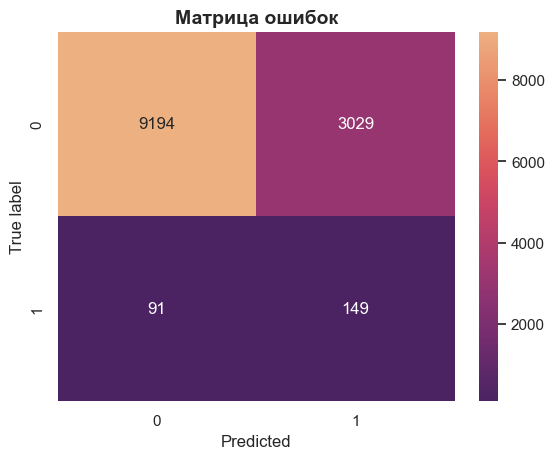

In [83]:
# построение матрицы ошибок
cm = confusion_matrix(y_test, lr_grid.predict(X_test))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='flare_r')
ax.set_title(
    'Матрица ошибок',
    fontsize=14,
    fontweight='bold'
)
plt.ylabel('True label')
plt.xlabel('Predicted')
plt.show()

__ПРОМЕЖУТОЧНЫЙ ВЫВОД:__

Матрица ошибок показывает, что в большей части случаем модель правильно классифицирует метку класса. Большая часть клиентов, которые вернутся правильно идентифицированы.

## Проверка модели на адекватность

Подготовим Pipeline c `DummyClassifier`.

In [84]:
pipeline_dummy = Pipeline([
    ('preprocessor', data_preprocessor),
    # инициализируем DummyClassifier, который всегда прогнозирует самое частое значение
    ('model', DummyClassifier(strategy='most_frequent'))
])

In [85]:
# обучаем DummyClassifier
pipeline_dummy.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['unique_days_count', 'purchases_count', 'avg_total_invoice',
       'open_email', 'click_email', 'purchase_email', 'click_mobile_push',
       'send_email', 'unsubscribe_email', 'hbq_spam_email', 'send_mobile_push',
       'open_mobile_push', 'purchase_mobile_push', 'subscribe_email',
       'complain_email', 'close_mobile_push', 'nunique_soft_bounce_email',
       'nunique_purchase_mobile_push', 'count_soft_bounce_mobile_push',
       'count_hbq_spam_email'],
      dtype='object'))])),
                ('model', DummyClassifier(strategy='most_frequent'))])

In [86]:
print_md(
    f'ROC_AUC на тесте для `LogisticRegression`: \
    __{roc_auc_score(y_test, lr_grid.predict_proba(X_test)[:,1])}__'
)
print_md(
    f'ROC_AUC на тесте для `DummyClassifier`: \
    __{roc_auc_score(y_test, pipeline_dummy.predict_proba(X_test)[:,1])}__'
)

ROC_AUC на тесте для `LogisticRegression`:     __0.7494320815948076__

ROC_AUC на тесте для `DummyClassifier`:     __0.5__

__ПРОМЕЖУТОЧНЫЙ ВЫВОД:__

Выбранная модель `LogisticRegression` показывает существенно лучшие результаты, чем `DummyClassifier`. Это говорит о том, что наша модель “умеет” извлекать важные зависимости из данных.

## Оценка важности признаков на SHAP-диаграмме

In [87]:
# подготовка данных (train)
X_train_transformed = pd.DataFrame(
    data = data_preprocessor.transform(X_train),
    columns = data_preprocessor.get_feature_names_out()
)

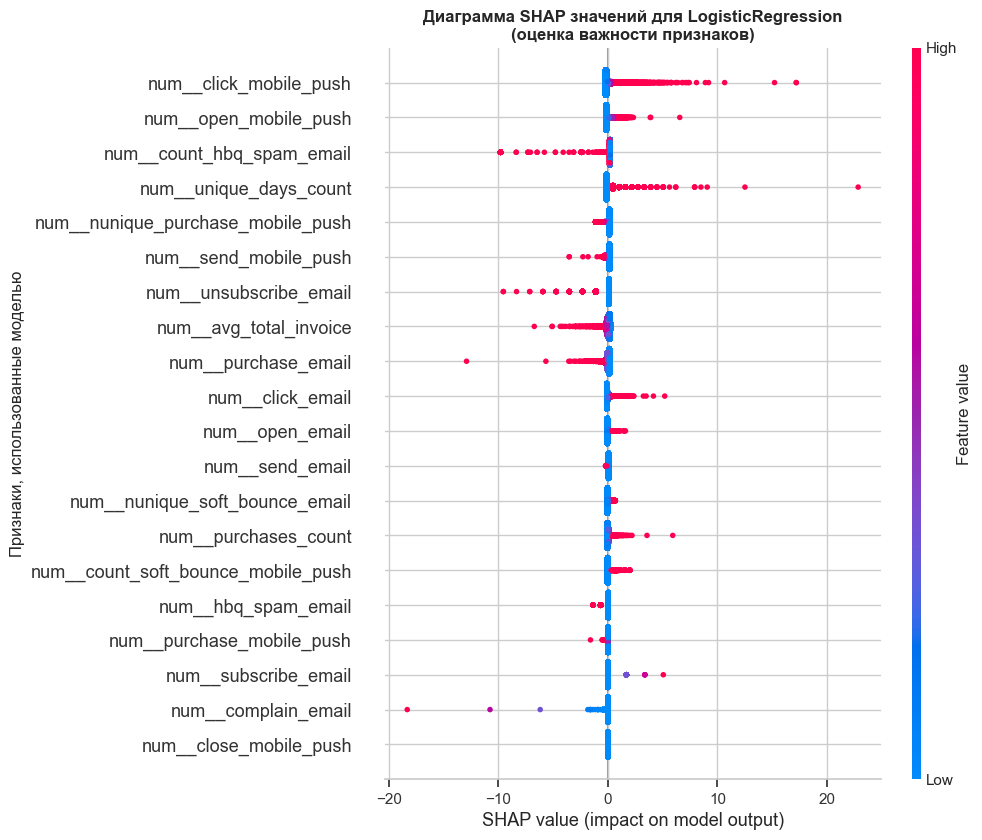

In [88]:
# построим диаграмму SHAP‑значений
plot_shap_beeswarm(
    model=lr_grid.best_estimator_['classifier'],
    X=X_train_transformed,
    title = 'Диаграмма SHAP значений для LogisticRegression\n(оценка важности признаков)',
    y_label = 'Признаки, использованные моделью'
)

__ПРОМЕЖУТОЧНЫЙ ВЫВОД:__

Наиболее важными признаками для модели являются:

- `click_mobile_push` (сколько раз клиент кликнул на push-уведомление)
- `open_mobile_push` (сколько push-уведомлений было открыто клиентом)
- `count_hbq_spam_email` (среднее количество жалоб на спам в рассылочной кампании)
- `unique_days_count` (количество уникалных дат когда клиент совершал покупку)
- `unsubscribe_email` (сколько раз клиент отписался от email-рассылки)
- `avg_total_invoice` (средний чек клиента)
- `purchases_count` (количество покупок клиента)
- `purchase_email` (количество покупок по email-рассылке)

## Общий вывод

### Описание проекта

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

### Цель проекта:

Предсказать вероятность покупки в течение 90 дней.

__Главные задачи__:

- загрузить и изучить данные
- провести предобработку и исследовательский анализ
- сконструировать новые признаки
- проверить на мультиколлинеарность
- создать и обучить модели
- исследовать значимость признаков
- максимизировать метрику __ROC-AUC__ и оценить качество модели 

### Краткий обзор проделанной работы

- загрузка и ознакомление с данными
- предварительная обработка
- разработка новых признаков
- проверка на мультиколлинеарность
- отбор финального набора обучающих признаков
- выбор и обучение моделей
- подбор гиперпараметров
- выбор лучшей модели по результатм крос-валидации
- итоговая оценка качества предсказания лучшей модели
- проверка модели на адекватность
- анализ важности признаков

### Использованные библиотеки и технологии:

- **Pandas**: для работы с данными, включая их обработку, преобразование и анализ.
- **Seaborn** и **Matplotlib**: для визуализации данных и построения графиков.
- **Phik**: для расчета корреляции с учетом категориалных признаков.
- **Scikit-learn**: библиотека для машинного обучения, предоставляющая инструменты для подготовки данных, работы с метриками и моделями.
- **Optuna**: платформа для автоматизированного поиска гиперпараметров. В проекте используется интеграция Optuna с Scikit-learn.
- **Imbalanced-learn**: используется для работы с несбалансированными данными, включая методы балансировки классов, такие как **SMOTETomek**, которые помогают комбинировать методы **undersampling and oversampling** чтобы сбалансировать классы.
- **LightGBM**: популярная библиотеки для градиентного бустинга.

### Полученные результаты:

Лучшие значения метрики метрик на тестовой выборке:

In [89]:
print_md(table_test)


|№ п/п|Метрика для модели `LogisticRegression`|Значение на тестовой выборке|
|-----|---------------------------------------|----------------------------|
|  1  |ROC-AUC|__0.749__|
|  2  |ACCURACY|__0.75__|
|  3  |F1|__0.087__|
|  4  |PRECISION|__0.047__|
|  5  |RECALL|__0.621__|


### Рекомендации заказчику

1. Линейная модель (`LogisticRegression`) показала лучшие результаты по метрике __ROC_AUC__. Рекомендуется к использованиию.
2. При сборе данных важно обратить внимание на следующие показатели:

- сколько раз клиент кликнул на push-уведомление
- сколько push-уведомлений было открыто клиентом
- среднее количество жалоб на спам в рассылочной кампании
- количество уникалных дат когда клиент совершал покупку
- сколько раз клиент отписался от email-рассылки
- средний чек клиента
- количество покупок клиента
- количество покупок по email-рассылке

3. Результаты модели можно было бы существенно улучшить, если бы данные были бы наиболее полные. Например информация о заказах клиента, неоплаченных товарах в корзине, расшифровка категорий покупок и другое.